<a href="https://colab.research.google.com/github/Sandhya-29/Glacier-Avalanche-Prediction/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
# from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'  # also try 'he_normal' but model not converging... 

image_directory = '/content/drive/MyDrive/Glacier_dataset/Unet/ori/'
mask_directory = '/content/drive/MyDrive/Glacier_dataset/Unet/seg/'


SIZE = 480
image_dataset = []  
mask_dataset = []  

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

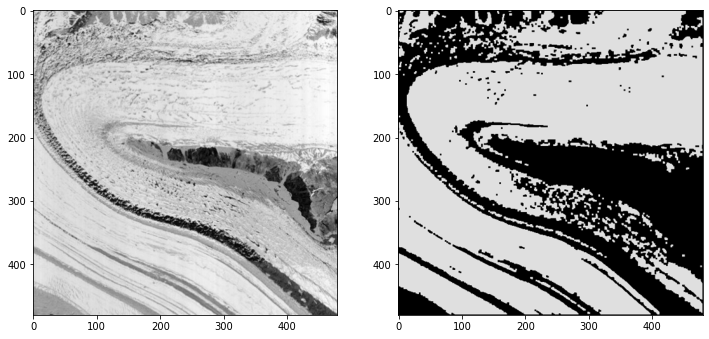

In [ ]:
#Normalize images

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()
    
    return model

image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 0)


import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (480, 480)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (480, 480)), cmap='gray')
plt.show()


In [ ]:
###############################################################
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()
for layer in model.layers:
    layer.trainable=True

from keras.utils.vis_utils import plot_model
plot_model(model,to_file="/content/drive/MyDrive/model.jpg",show_shapes=True,show_layer_names=True)

history = model.fit(X_train, y_train, 
                    batch_size = 2, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 480, 480, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 480, 480, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

2/2 [==============================] - 33s 10s/step - loss: 0.3803 - accuracy: 0.4698
Accuracy =  46.97848856449127 %


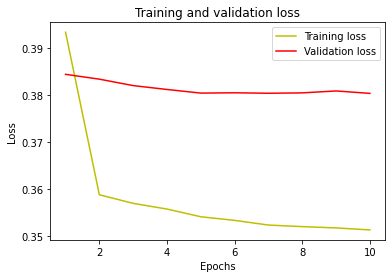

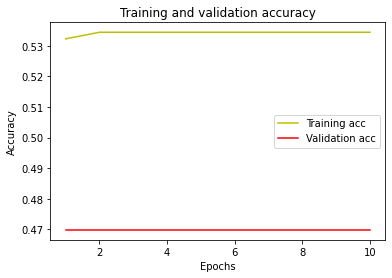

2/2 [==============================] - 26s 9s/step
IoU socre is:  0.0
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 480, 480, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 480, 480, 16  0           ['conv2d_57[0][0]']              
                      

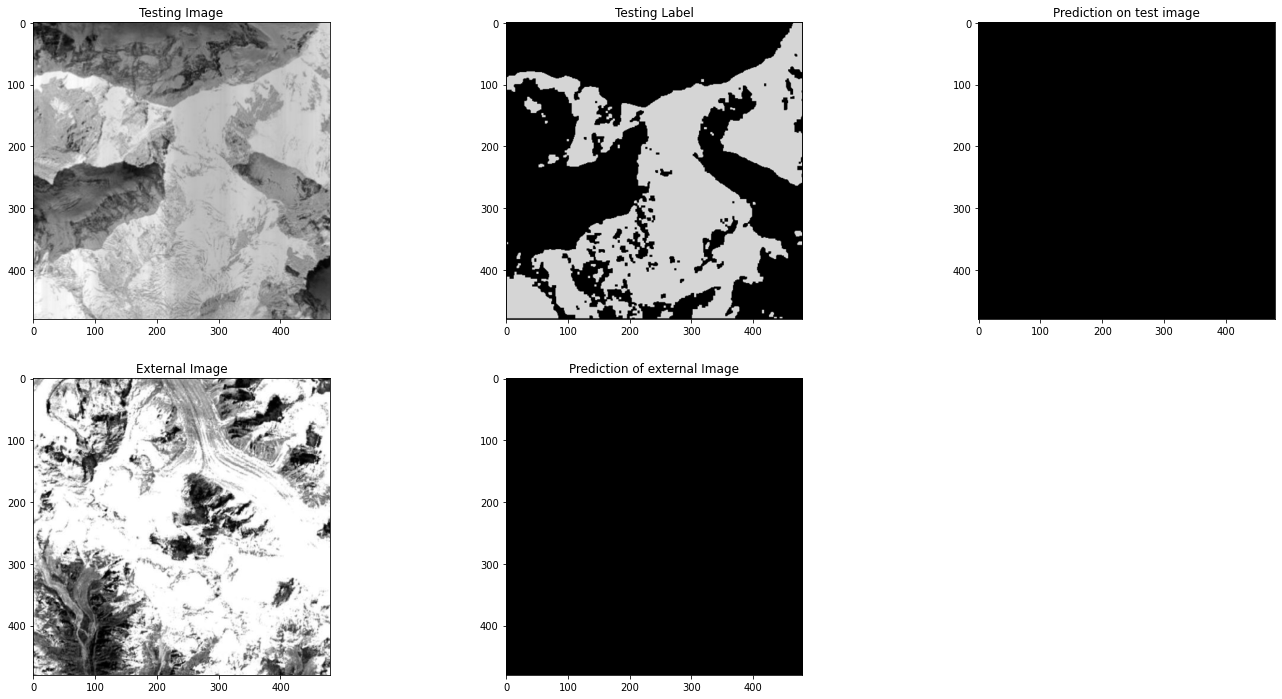

In [ ]:
#model.save('/content/drive/MyDrive/Glacier_dataset/glacier_test.hdf5')


_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##################################
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
model = get_model()
#model.load_weights('/content/drive/MyDrive/Glacier_dataset/glacier_test.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

test_img_number = random.randint(0, len(X_test))
test_img = X_test[0]
ground_truth=y_test[0]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

test_img_other = cv2.imread('/content/drive/MyDrive/Glacier_dataset/Charobari_Resized/12.2012.jpg', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other=cv2.resize(test_img_other,(480,480))
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

1/1 [==============================] - 1s 569ms/step


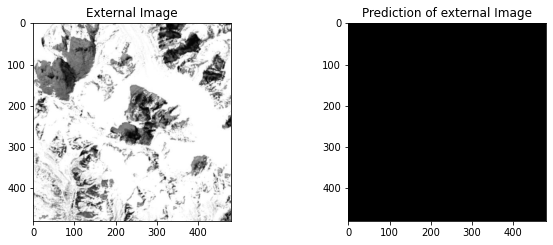

1/1 [==============================] - 1s 595ms/step


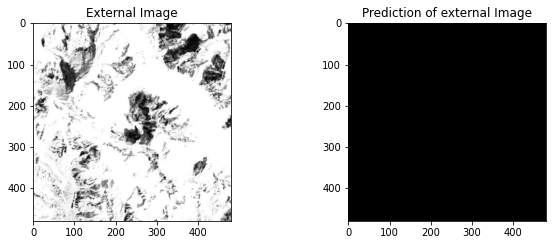

1/1 [==============================] - 1s 610ms/step


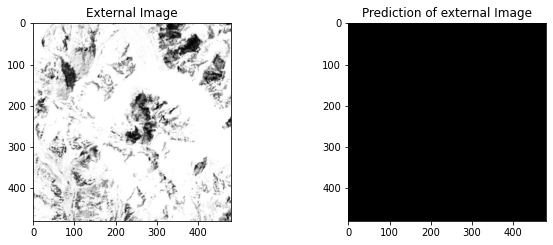

1/1 [==============================] - 1s 556ms/step


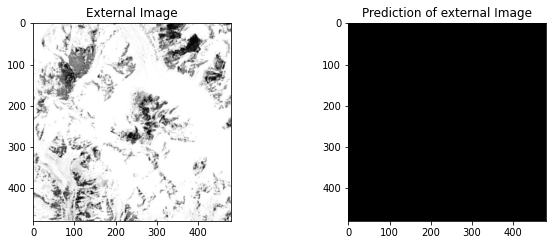

1/1 [==============================] - 1s 570ms/step


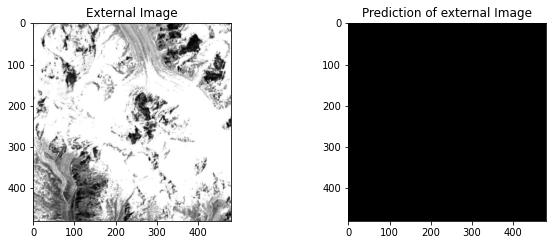

1/1 [==============================] - 1s 568ms/step


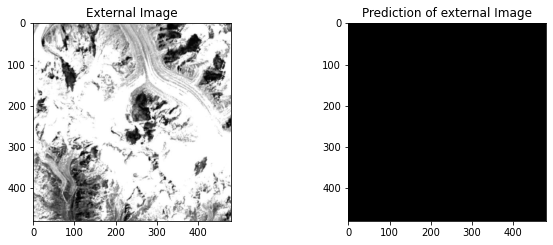

1/1 [==============================] - 1s 565ms/step


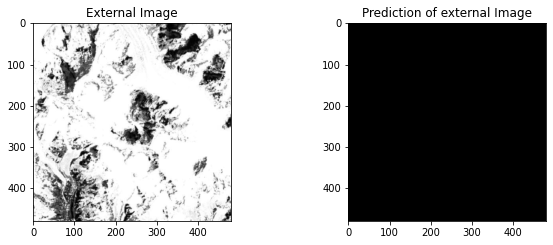

1/1 [==============================] - 1s 549ms/step


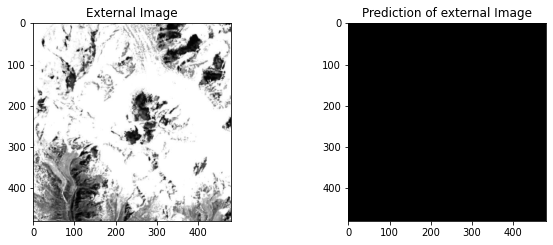

1/1 [==============================] - 1s 559ms/step


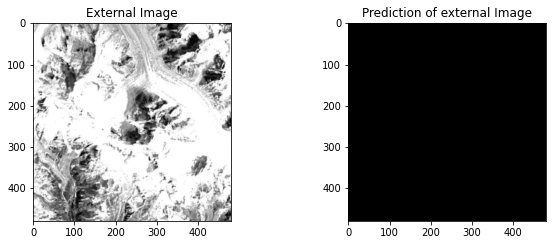

1/1 [==============================] - 1s 578ms/step


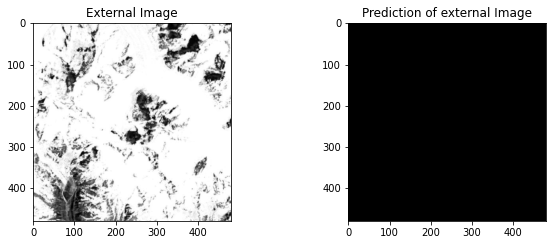

1/1 [==============================] - 1s 570ms/step


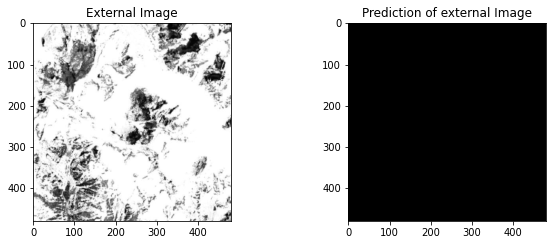

1/1 [==============================] - 1s 601ms/step


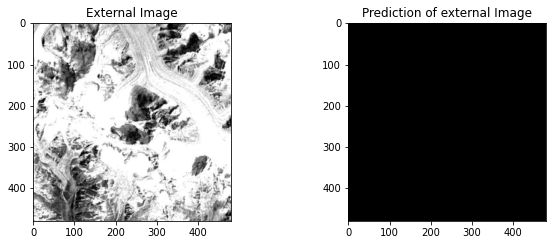

1/1 [==============================] - 1s 557ms/step


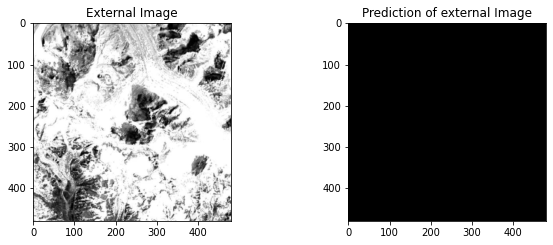

1/1 [==============================] - 1s 547ms/step


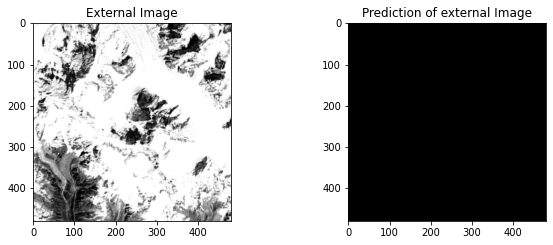

1/1 [==============================] - 1s 570ms/step


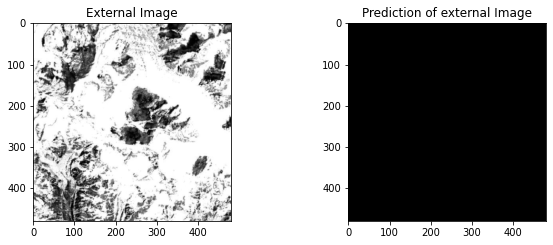

1/1 [==============================] - 1s 562ms/step


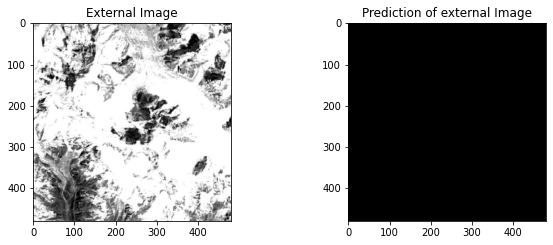

1/1 [==============================] - 1s 572ms/step


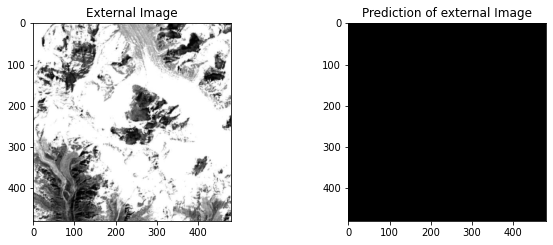

1/1 [==============================] - 1s 554ms/step


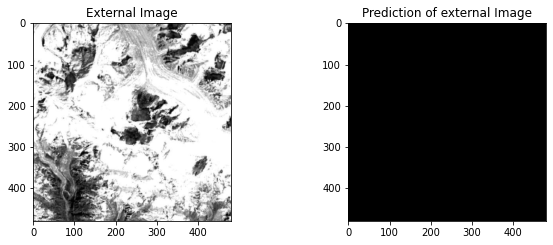

1/1 [==============================] - 1s 729ms/step


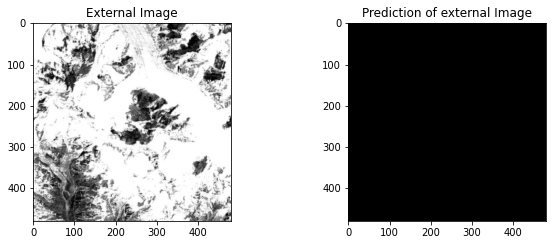

1/1 [==============================] - 1s 1s/step


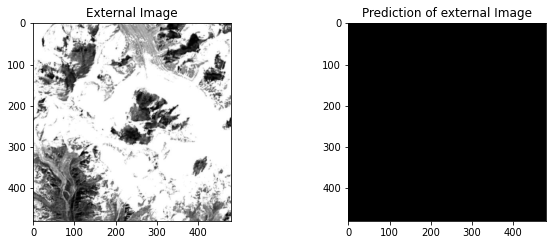

1/1 [==============================] - 1s 1s/step


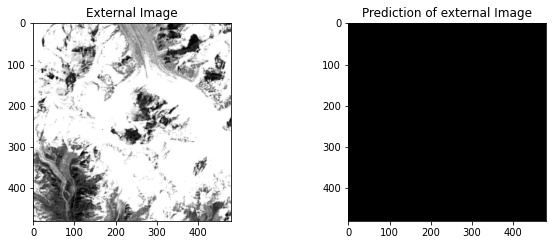

1/1 [==============================] - 1s 559ms/step


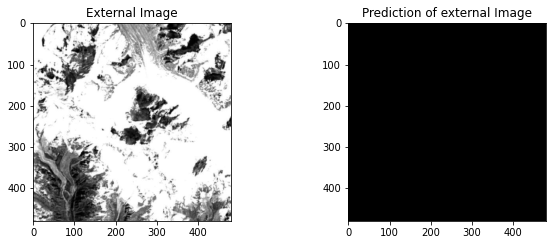

1/1 [==============================] - 1s 573ms/step


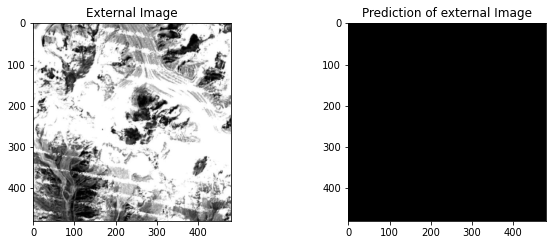

1/1 [==============================] - 1s 576ms/step


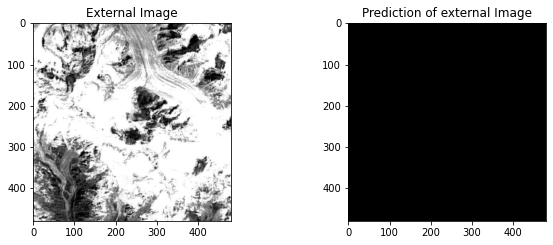

1/1 [==============================] - 1s 560ms/step


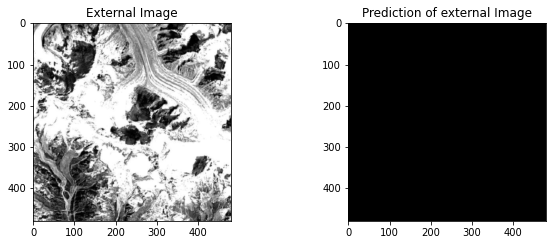

1/1 [==============================] - 1s 549ms/step


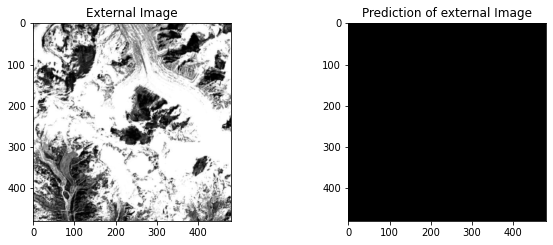

1/1 [==============================] - 1s 581ms/step


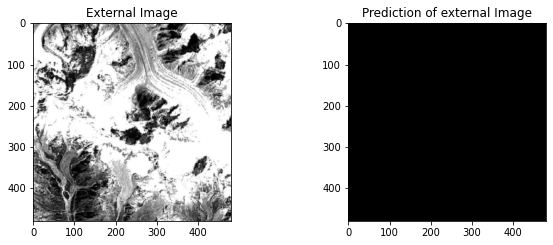

1/1 [==============================] - 1s 568ms/step


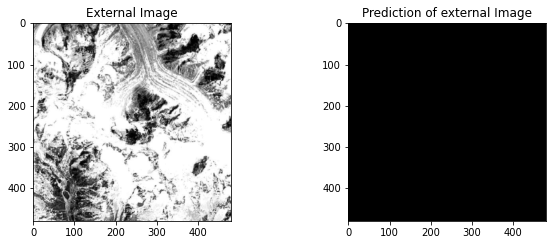

1/1 [==============================] - 1s 554ms/step


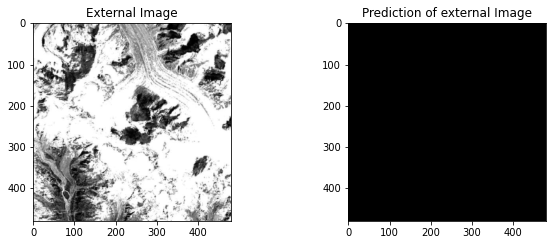

1/1 [==============================] - 1s 573ms/step


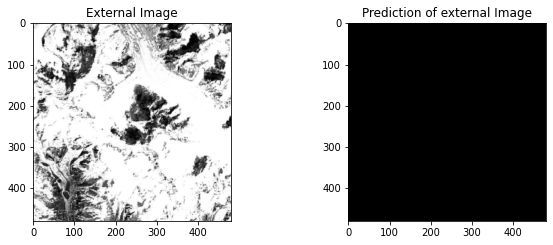

1/1 [==============================] - 1s 570ms/step


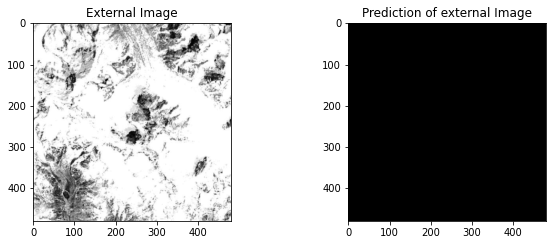

1/1 [==============================] - 1s 579ms/step


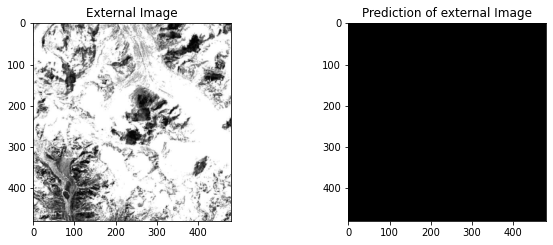

In [ ]:
path = '/content/drive/MyDrive/Glacier_dataset/Charobari_Resized'
for i in range(1989,2021):
  k= cv2.imread('/content/drive/MyDrive/Glacier_dataset/Charobari_Resized/12.'+str(i)+'.jpg')
  k=cv2.resize(k,(480,480))
  test_img_other=cv2.imread('/content/drive/MyDrive/Glacier_dataset/Charobari_Resized/12.'+str(i)+'.jpg', 0)
  #test_img_other = cv2.imread('data/test_images/img8.tif', 0)
  test_img_other=cv2.resize(test_img_other,(480,480))
  test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
  test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
  test_img_other_input=np.expand_dims(test_img_other_norm, 0)

  prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

  plt.figure(figsize=(16, 8))
  plt.subplot(234)
  plt.title('External Image')
  plt.imshow(test_img_other, cmap='gray')
  plt.subplot(235)
  plt.title('Prediction of external Image')
  plt.imshow(prediction_other, cmap='gray')
  plt.show()

  plt.imsave('/content/drive/MyDrive/Glacier_dataset/Unet/res/'+str(i)+'_pred.png', prediction_other)
  plt.imsave('/content/drive/MyDrive/Glacier_dataset/Unet/res/'+str(i)+'.png', k)

1/1 [==============================] - 1s 585ms/step


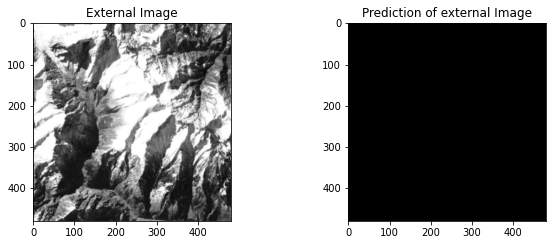

1/1 [==============================] - 1s 563ms/step


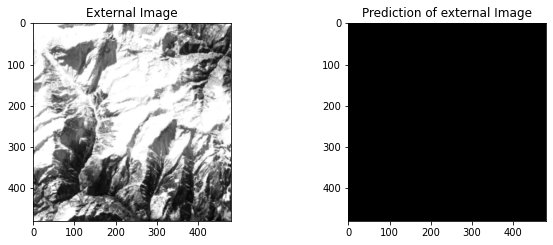

(480, 480)

In [ ]:
# k= cv2.imread(os.path.join(path,image))
test_img_other=cv2.imread('/content/drive/MyDrive/Glacier_dataset/Screenshot (24).png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other=cv2.resize(test_img_other,(480,480))
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.1).astype(np.uint8)

plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()
plt.imsave('/content/drive/MyDrive/Glacier_dataset/ss_24.png', k)
test_img_other=cv2.imread('/content/drive/MyDrive/Glacier_dataset/Screenshot (26).png', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other=cv2.resize(test_img_other,(480,480))
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)


prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.1).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()
plt.imsave('/content/drive/MyDrive/Glacier_dataset/ss_27.png', k)
prediction.shape

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
im = Image.open('/content/drive/MyDrive/Glacier_dataset/Unet/res/1989_pred.png')
for pixel in im.getdata():
    print(pixel)

Streaming output truncated to the last 5000 lines.
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 255)
(68, 1, 84, 25

In [ ]:
from PIL import Image
year=1989
myDict={}
myDict2={}
for i in range(1989,2021):
  im = Image.open('/content/drive/MyDrive/Glacier_dataset/Unet/res/'+str(i)+'_pred.png')
  black = 0
  area = 0
  
  for pixel in im.getdata():
      if pixel == (253, 231, 36, 255): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
          area += 1
      black+=1
  myDict[i]=area*0.56
  print(i,area,black)


for i in myDict:
  print(i,myDict[i])

1989 0 230400
1990 0 230400
1991 0 230400
1992 0 230400
1993 0 230400
1994 0 230400
1995 0 230400
1996 0 230400
1997 0 230400
1998 0 230400
1999 0 230400
2000 0 230400
2001 0 230400
2002 0 230400
2003 0 230400
2004 0 230400
2005 0 230400
2006 0 230400
2007 0 230400
2008 0 230400
2009 0 230400
2010 0 230400
2011 0 230400
2012 0 230400
2013 0 230400
2014 0 230400
2015 0 230400
2016 0 230400
2017 0 230400
2018 0 230400
2019 0 230400
2020 0 230400
1989 0.0
1990 0.0
1991 0.0
1992 0.0
1993 0.0
1994 0.0
1995 0.0
1996 0.0
1997 0.0
1998 0.0
1999 0.0
2000 0.0
2001 0.0
2002 0.0
2003 0.0
2004 0.0
2005 0.0
2006 0.0
2007 0.0
2008 0.0
2009 0.0
2010 0.0
2011 0.0
2012 0.0
2013 0.0
2014 0.0
2015 0.0
2016 0.0
2017 0.0
2018 0.0
2019 0.0
2020 0.0


In [ ]:
import csv  

header = ['year', 'area']
data=[]
for i in myDict:
    data.append([i,myDict[i]])
with open('/content/drive/MyDrive/glacier.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


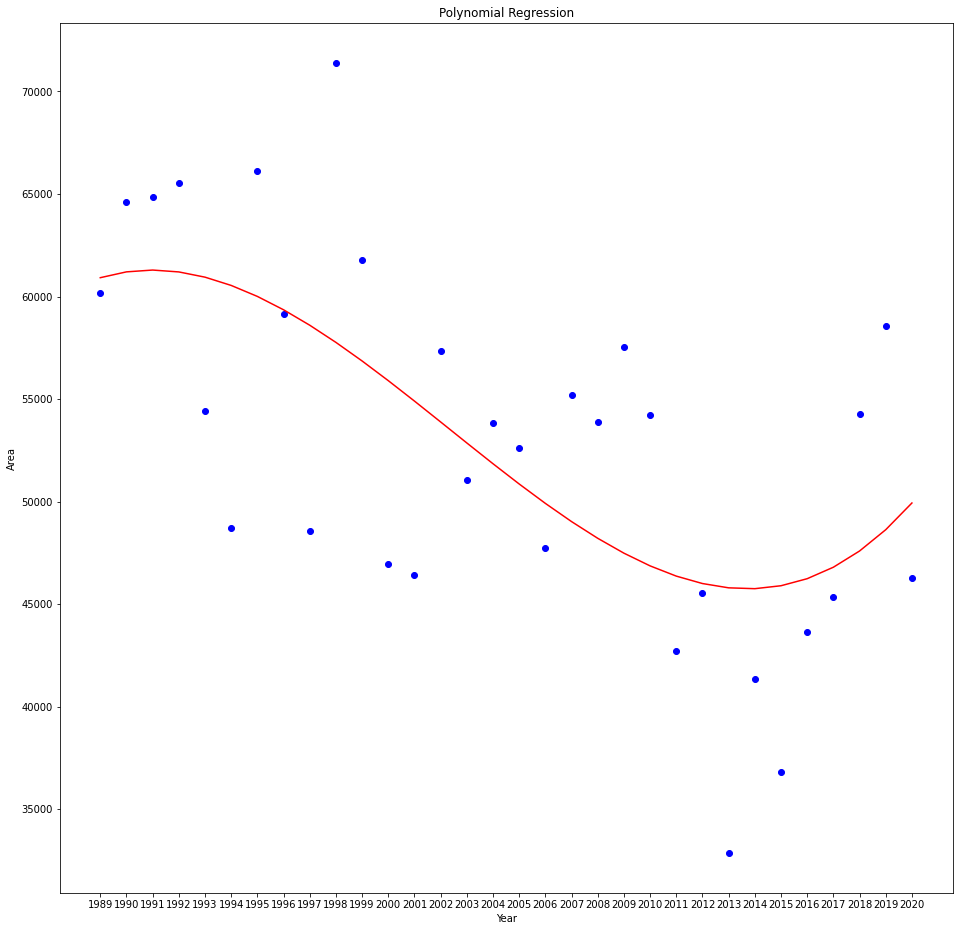

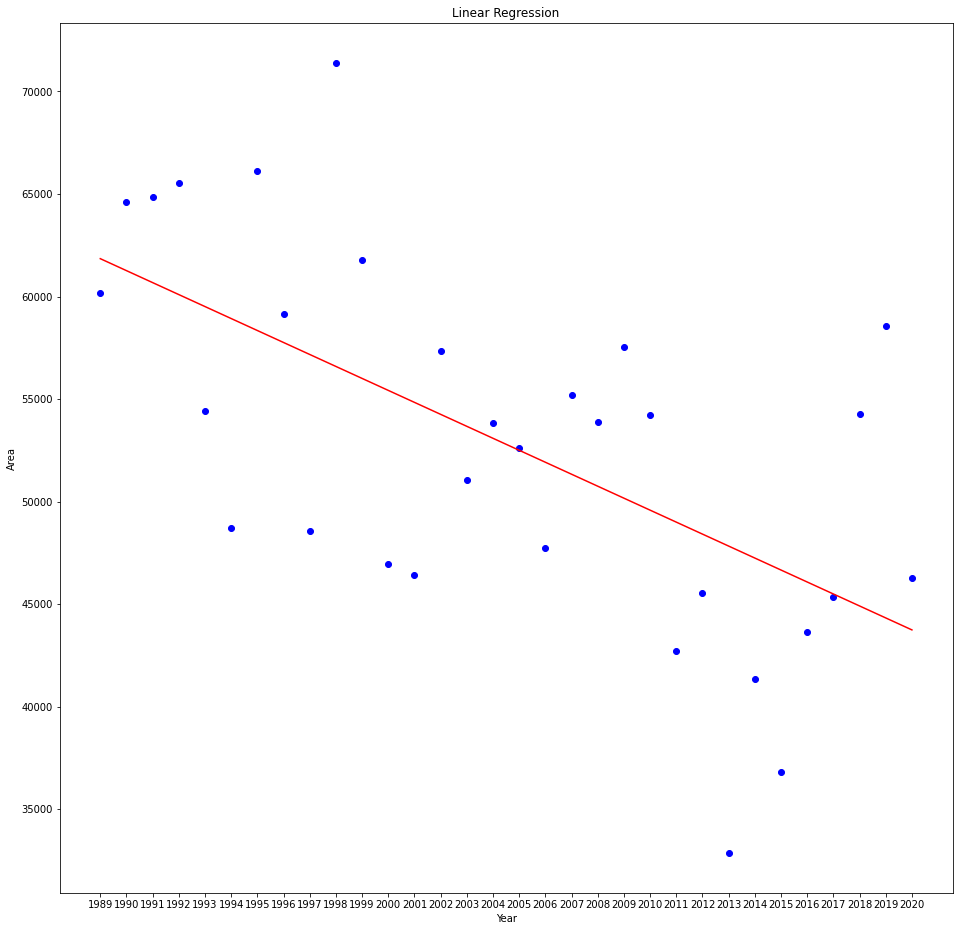

[60162.48 64599.36 64851.36 65530.08 54403.44 48723.92 66137.68 59152.8
 48557.04 71409.52 61768.56 46953.2  46411.68 57324.4  51038.96 53838.96
 52590.16 47713.12 55211.52 53868.08 57536.08 54227.04 42708.4  45562.72
 32848.48 41366.08 36820.56 43627.36 45329.76 54265.12 58573.76 46295.2 ]
Mean squared error for Linear Regression 48922075.476780854
Mean squared error for Polynomial Regression 44619596.12598782


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
# Importing the dataset
datas = pd.read_csv('/content/drive/MyDrive/Glacier_dataset/glaciers.csv')
# print(datas.head())
X = datas.iloc[:, 0:1].values
y = datas.iloc[:, 1].values 

# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X, y)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X)
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)
plt.figure(figsize=(16,16))
plt.scatter(X, y, color = 'blue')
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red')
plt.xticks(np.arange(min(X), max(X)+1, 1.0))
plt.title('Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Area')
plt.show(block=True)

plt.figure(figsize=(16,16))
plt.scatter(X, y, color = 'blue')
plt.plot(X, lin.predict(X), color = 'red')
plt.xticks(np.arange(min(X), max(X)+1, 1.0))
plt.title('Linear Regression')
plt.xlabel('Year')
plt.ylabel('Area')

  
plt.show()
print(y)
#mse_error
from sklearn.metrics import mean_squared_error
print("Mean squared error for Linear Regression" ,mean_squared_error(y, lin.predict(X)))
print("Mean squared error for Polynomial Regression", mean_squared_error(y, lin2.predict(poly.fit_transform(X))))


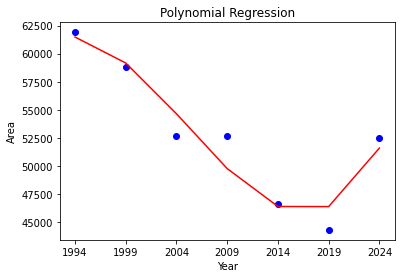

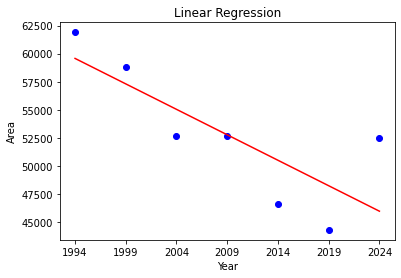

Mean squared error for Linear Regression 12289931.780544162
Mean squared error for Polynomial Regression 2505862.767555042


0.9238618817433613

In [ ]:
import numpy as np
k=1989
m=1989
lstX=[]
lsty=[]
for i in range(0,len(y),5):
  lsty.append(np.mean(y[i:i+5]))
  lstX.append(list([X[i][0]+5]))
lstX=np.array(lstX)
lsty=np.array(lsty)
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(lstX, lsty)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3)
lstX_poly = poly.fit_transform(lstX)

poly.fit(lstX_poly, lsty)
lin2 = LinearRegression()
lin2.fit(lstX_poly, lsty)
plt.scatter(lstX, lsty, color = 'blue')
plt.plot(lstX, lin2.predict(poly.fit_transform(lstX)), color = 'red')
plt.xticks(np.arange(min(lstX), max(lstX)+1, 5.0))
plt.title('Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Area')
plt.show(block=True)

plt.scatter(lstX, lsty, color = 'blue')
plt.plot(lstX, lin.predict(lstX), color = 'red')
plt.xticks(np.arange(min(lstX), max(lstX)+1, 5.0))
plt.title('Linear Regression')
plt.xlabel('Year')
plt.ylabel('Area')
plt.show()
print("Mean squared error for Linear Regression" ,mean_squared_error(lsty, lin.predict(lstX)))
print("Mean squared error for Polynomial Regression", mean_squared_error(lsty, lin2.predict(poly.fit_transform(lstX))))
from sklearn.metrics import r2_score
r2_score(lsty, lin2.predict(poly.fit_transform(lstX)))

[0 2 2 2 0 1 2 0 1 2 2 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1]


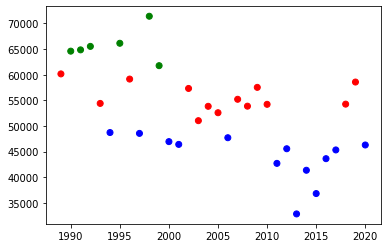

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Importing the dataset
datas = pd.read_csv('/content/drive/MyDrive/Glacier_dataset/glaciers.csv')
# datas.loc[datas.index.max()+1] = [2021, 70000]
# datas.to_csv("/content/drive/MyDrive/Glacier_dataset/glacier.csv", index=False)

x = datas.iloc[:, 0:2]
kmeans = KMeans(3)
kmeans.fit(x)
identified_clusters = kmeans.fit_predict(x)
print(identified_clusters)
data_with_clusters = datas.copy()
data_with_clusters['Clusters'] = identified_clusters 
# plt.figure(figsize=(8,8))
import matplotlib.colors as mcols
cmap = mcols.ListedColormap(['r','b','g'])
plt.scatter(datas.iloc[: , 0:1].values,datas.iloc[:, 1].values,c=data_with_clusters['Clusters'],cmap=cmap)
# plt.xticks(np.arange(min(datas.iloc[: , 0:1].values), max(datas.iloc[: , 0:1].values)+1, 1.0))

[14815.36, 12714.239999999998, 12278.560000000005, 11518.64, 11126.64, 10595.760000000002, 9640.960000000006, 6984.87999999999, 6285.440000000002, 5679.520000000004, 4877.040000000001, 4545.520000000004, 3309.040000000001, 1343.439999999995, 1248.7999999999956, 541.5199999999968, 0, -252.0, -678.7200000000012, -1702.4000000000015, -2800.0, -2854.3199999999997, -3668.0, -4308.639999999999, -4436.879999999997, -6806.800000000003, -7498.399999999994, -8517.599999999999, -8935.36, -10912.720000000001, -17413.759999999995, -22852.480000000003]


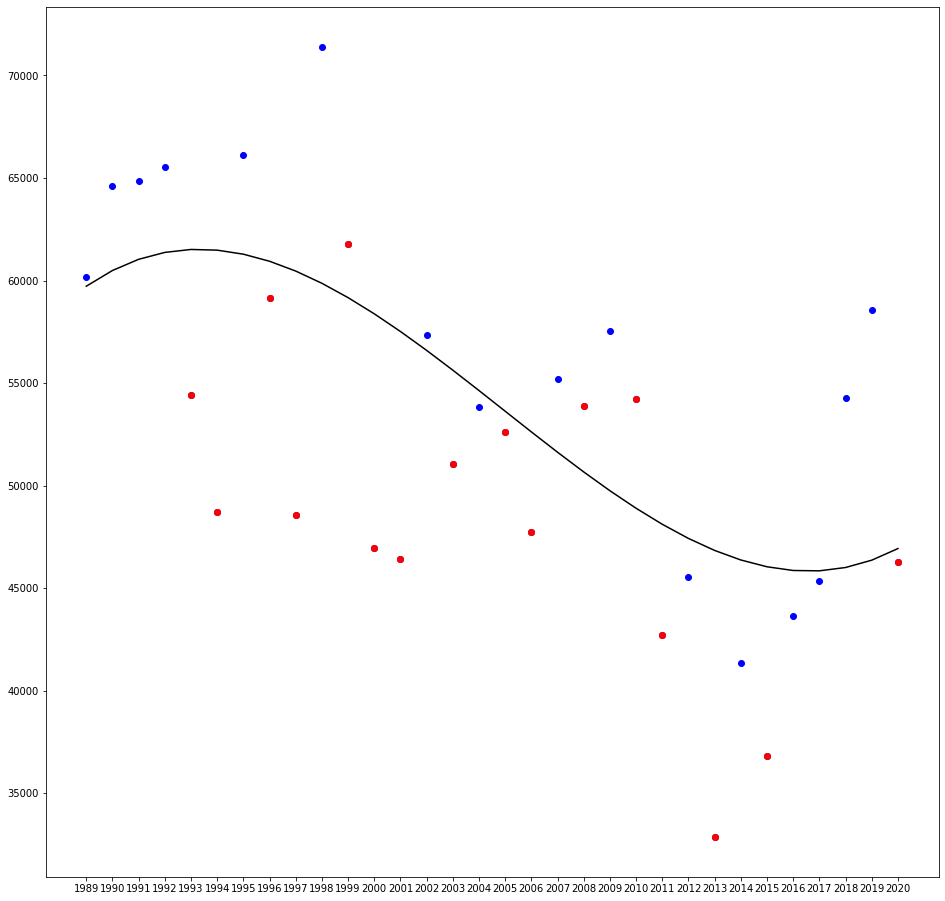

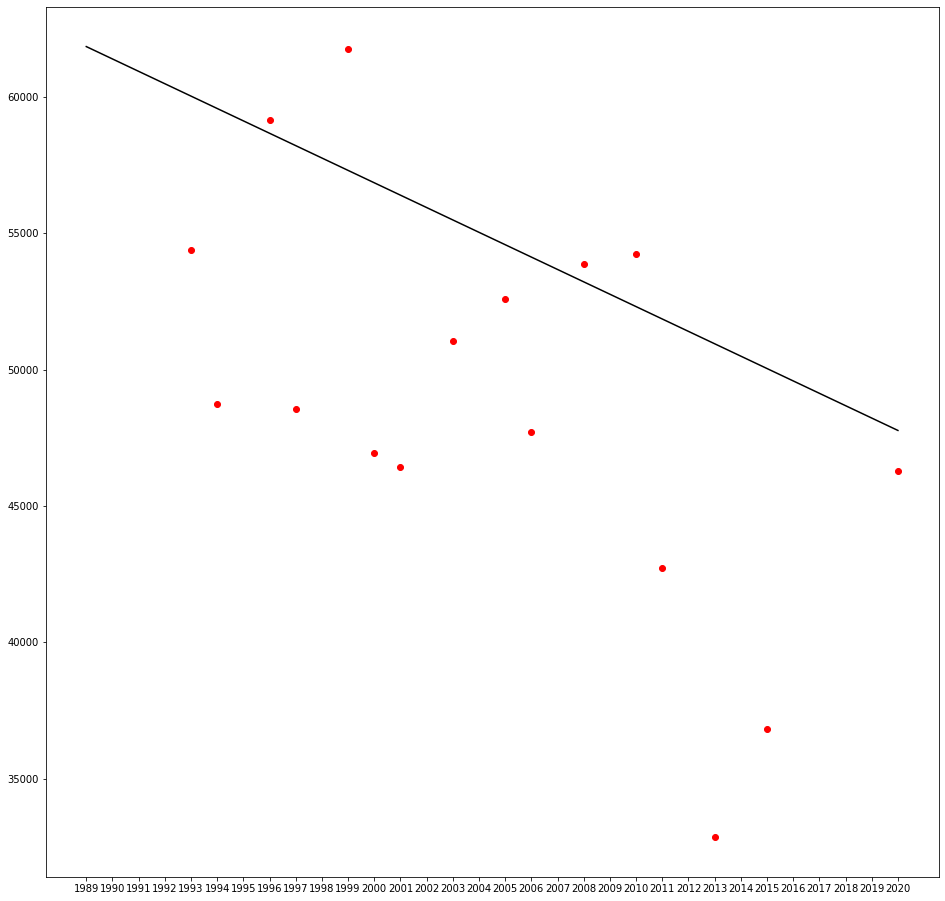

In [ ]:
new=[0]
for i in range(len(y)-1):
  new.append(y[i]-y[i+1])
print(sorted(new,reverse=True))
plt.figure(figsize=(16,16))

plt.scatter(X,y,color="blue")
for i in range(len(X)):
  if new[i]>0:
    plt.scatter(X[i],y[i],color="red")

plt.xticks(np.arange(min(X), max(X)+1, 1.0))
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'black')
plt.show(block=True)
plt.figure(figsize=(16,16))
for i in range(len(X)):
  if new[i]>0:
    plt.scatter(X[i],y[i],color="red")
plt.plot(X, lin.predict(X), color = 'black')

plt.xticks(np.arange(min(X), max(X)+1, 1.0))
plt.show()

In [ ]:
lst=[]
max=0
diff=[]
risky=[]
for i in range(0,2021-1989):
  if y[i+1]-y[i] < 0:
    lst.append(y[i])
  lst.append(float(lin2.predict(poly.fit_transform([[i]]))))

for i in range(len(lst)):
  if lst[i]-y[i]>max or lst[i]-y[i] in diff:
    max=lst[i]-y[i]
    diff.append(max)
    risky.append([X[i][0]])
risky
plt.scatter(X,y,color="blue")

# for i in range(len(X)):
#   if X[i] in risky:
#     plt.scatter(X[i],y[i],color="red")
# plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'black')
plt.show()


IndexError: ignored

In [ ]:
new=[0]
for i in range(len(y)-1):
  new.append(y[i]-y[i+1])
print(new)
count=0
diff=0
for i in new:
  if i>=0:
    count+=1
    diff+=i
print(diff/count)

[0, -4436.879999999997, -252.0, -678.7200000000012, 11126.64, 5679.520000000004, -17413.759999999995, 6984.87999999999, 10595.760000000002, -22852.480000000003, 9640.960000000006, 14815.36, 541.5199999999968, -10912.720000000001, 6285.440000000002, -2800.0, 1248.7999999999956, 4877.040000000001, -7498.399999999994, 1343.439999999995, -3668.0, 3309.040000000001, 11518.64, -2854.3199999999997, 12714.239999999998, -8517.599999999999, 4545.520000000004, -6806.800000000003, -1702.4000000000015, -8935.36, -4308.639999999999, 12278.560000000005]
6912.080000000003
